Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---

# Permutation & Boosting

- Get **permutation importances** for model interpretation and feature selection
- Use xgboost for **gradient boosting**

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:

- category_encoders
- matplotlib
- numpy
- pandas
- scikit-learn
- [**xgboost**](https://xgboost.readthedocs.io/en/latest/)

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone 
#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
DATA_PATH = '../data/'

We'll go back to Tanzania Waterpumps for this lesson.

In [3]:

from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', parse_dates=['date_recorded']), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('date_recorded')

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', parse_dates=['date_recorded']).set_index('date_recorded')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')


# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X.index.year
    X['month_recorded'] = X.index.month
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [4]:
# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [5]:
pipeline = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
           

In [6]:
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8107744107744108


## Get **permutation importances** for model interpretation and feature selection
### I Gini impurity

In [7]:
gini_importance = pipeline.named_steps['randomforestclassifier'].feature_importances_

In [8]:
gini_importance

array([0.02359769, 0.0318741 , 0.04492404, 0.02601559, 0.08439744,
       0.08405583, 0.06034385, 0.00096599, 0.01396505, 0.05693386,
       0.01435839, 0.01355506, 0.01639368, 0.02286126, 0.03956963,
       0.032345  , 0.0078764 , 0.01248804, 0.02435806, 0.00703394,
       0.03186388, 0.0193069 , 0.01648908, 0.0259426 , 0.01125796,
       0.0052247 , 0.02137972, 0.0077553 , 0.00822914, 0.09003699,
       0.01370988, 0.01280519, 0.00454068, 0.03669164, 0.0229582 ,
       0.00479539, 0.01557274, 0.03352712])

In [9]:
column_name = X_train.columns

Text(0, 0.5, 'feature name')

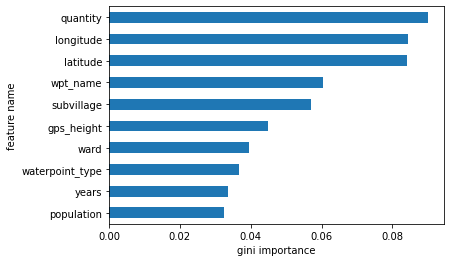

In [10]:
pd.Series(gini_importance, index=column_name).sort_values().tail(10).plot(kind='barh')
plt.xlabel('gini importance')
plt.ylabel('feature name')

### II drop column importances

In [11]:
accuracy_before = pipeline.score(X_val, y_val)

In [12]:
cols_drop = X_val.columns
acc_diff = []
for col in cols_drop:

    X_train_drop = X_train.drop(columns=col)

    pipeline_drop = make_pipeline(
        OrdinalEncoder(), 
        SimpleImputer(strategy='median'), 
        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    )

    pipeline_drop.fit(X_train_drop, y_train)
    X_val_drop = X_val.drop(columns=col)
    accuracy_after = pipeline_drop.score(X_val_drop, y_val)
    print(col)
    accuracy_diff = accuracy_before - accuracy_after
    acc_diff.append(accuracy_diff)

amount_tsh
funder
gps_height
installer
longitude
latitude
wpt_name
num_private
basin
subvillage
region
region_code
district_code
lga
ward
population
public_meeting
scheme_management
scheme_name
permit
construction_year
extraction_type
extraction_type_group
extraction_type_class
management
management_group
payment
water_quality
quality_group
quantity
source
source_type
source_class
waterpoint_type
waterpoint_type_group
year_recorded
month_recorded
years


Text(0, 0.5, 'feature name')

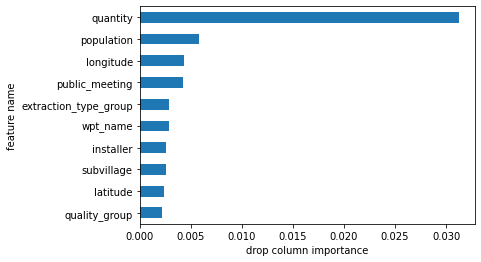

In [13]:
pd.Series(acc_diff, index=cols_drop).sort_values().tail(10).plot(kind='barh')
plt.xlabel('drop column importance')
plt.ylabel('feature name')

### III Permutation Importance

In [41]:
Image(url= "https://i.imgur.com/h17tMUU.png")

In [14]:
from sklearn.inspection import permutation_importance
per_imp = permutation_importance(pipeline, 
                                 X_val, 
                                 y_val,
                                 n_repeats=5, 
                                 n_jobs=-1, 
                                 random_state=42 )

Text(0, 0.5, 'feature name')

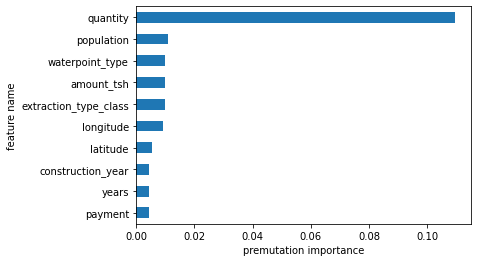

In [15]:
pd.Series(per_imp['importances_mean'], index=cols_drop).sort_values().tail(10).plot(kind='barh')
plt.xlabel('premutation importance')
plt.ylabel('feature name')

#### Use the top five features to train the model

In [16]:
X_train_top_5 = X_train[pd.Series(per_imp['importances_mean'], index=cols_drop).sort_values().tail(5).index]
X_val_top_5 =  X_val[pd.Series(per_imp['importances_mean'], index=cols_drop).sort_values().tail(5).index]

In [17]:
pipeline_top_5 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline_top_5.fit(X_train_top_5, y_train)
print('Validation Accuracy', pipeline_top_5.score(X_val_top_5, y_val))

Validation Accuracy 0.7154882154882155


##  Use xgboost for **gradient boosting**

In [39]:
Image(url= "https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG")
## The below diagram explains how gradient boosted trees are trained for regression problems.

In [33]:
# xgboost
# 1. add more regularization terms
# 2. compute faster
# 3. deal with missing values
from xgboost import XGBClassifier
model_xgb = make_pipeline(OrdinalEncoder(),
                         XGBClassifier(n_estimators=100,
                                      max_depth=10,
                                      learning_rate=1e-3,
                                      n_jobs=10))

In [34]:
model_xgb.fit(X_train, y_train)

/Users/sisichen/.local/share/virtualenvs/Unit2-sprint3-ds25-B8QTsEAs/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:14:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
   

In [35]:
print('Validation Accuracy',model_xgb.score(X_train, y_train))
print('Validation Accuracy',model_xgb.score(X_val, y_val))

Validation Accuracy 0.8035353535353535
Validation Accuracy 0.7721380471380471
